In [85]:
import sys, os
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Iterable, List
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

import collections
import pandas as pd 
import numpy as np
import random 
from torch.utils.data import DataLoader, random_split
import scanpy as sc

from model import Encoder, Decoder, OutputLayer, FC
from loss_function import ZINB, maximum_mean_discrepancy
from utils import plot_train

In [86]:
# Data
path_pool = [
    r"./data/mtx_0.mtx", 
    r'./data/GSE65525/GSM1599497_ES_d2_LIFminus.csv', 
    r'./data/GSE65525/GSM1599498_ES_d4_LIFminus.csv', 
    r'./data/GSE65525/GSM1599499_ES_d7_LIFminus.csv'
    ]
# path_mtx = path_pool[0]
data_test= sc.read_csv(path_pool[1])
# data_test = sc.read_mtx(path_mtx)

In [87]:
# PREVIEW
load_data = data_test.T.copy()
sc.pp.filter_genes(load_data, min_cells=50)
print(data_test.shape, load_data.shape)

(24175, 303) (303, 6404)


In [88]:
batch_size = 32
all_data = np.array(load_data.X)

seed = 222
random.seed(seed)

m = len(all_data)
print(m)

train_data, test_data = random_split(dataset=all_data, lengths=[int(m - m * 0.2), int(m * 0.2) + 1])

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

303


In [89]:
net_struc = [all_data.shape[1], 1024, 512, 256, 128, 64]

encoder = Encoder(features=net_struc)
decoder = Decoder(features=net_struc[1:][::-1])
output_layer = OutputLayer(net_struc[0], net_struc[1])

loss_fn = nn.MSELoss()

# Define Optimizer
lr = 1e-4

#Random seed
torch.manual_seed(seed)
param_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(param_to_optimize, lr=lr, weight_decay=1e-05)

In [90]:
# Training
def train_epoch(encoder, decoder, dataloader, optimizer):
    encoder.train()
    decoder.train()
    output_layer.train()
    train_loss = 0.0
    for sc_data_batch in dataloader:
        # Encode
        encoded_data = encoder(sc_data_batch)
        # Decode
        decoded_data = decoder(encoded_data)

        # Compute params for DCA
        mean_param, pi_param, theta_param = output_layer(decoded_data)

        # Evaluate loss
        zinb = ZINB(pi_param, theta=theta_param)
        zinb_loss = (zinb.loss(mean_param, sc_data_batch))
        mmd_loss = maximum_mean_discrepancy(mean_param, sc_data_batch)
        loss = zinb_loss * 0.6 + mmd_loss * 0.4
        
        # Backword 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    return train_loss / len(dataloader.dataset)

In [91]:
# Testing func
def test_epoch(encoder, decoder, dataloader):
    encoder.eval()
    decoder.eval()
    output_layer.eval()
    test_loss = 0.0
    with torch.no_grad(): # Don't track gradients
        for sc_data_batch in dataloader:
            # Encode
            encoded_data = encoder(sc_data_batch)
            # Decode
            decoded_data = decoder(encoded_data)
            # Compute params for DCA
            mean_param, pi_param, theta_param = output_layer(decoded_data)

            zinb = ZINB(pi_param, theta=theta_param)

            zinb_loss = (zinb.loss(mean_param, sc_data_batch))
            mmd_loss = maximum_mean_discrepancy(mean_param, sc_data_batch)
            loss = zinb_loss * 0.6 + mmd_loss * 0.4
            
            test_loss += loss.item()
    return test_loss / len(dataloader.dataset)


 EPOCH 1/50 	 train loss 0.21051151299279583 	 test loss 0.29573221675685196

 EPOCH 2/50 	 train loss 0.20984534389716536 	 test loss 0.29190779514000065

 EPOCH 3/50 	 train loss 0.2097755936551685 	 test loss 0.2903257901551294

 EPOCH 4/50 	 train loss 0.20951458048229374 	 test loss 0.28940005380599226

 EPOCH 5/50 	 train loss 0.20919504835585917 	 test loss 0.2874959101442431


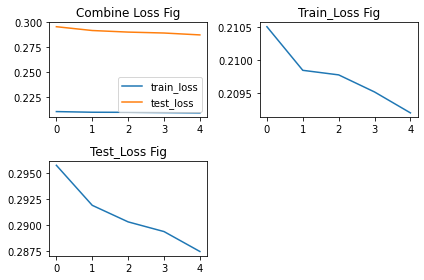


 EPOCH 6/50 	 train loss 0.20955384270218777 	 test loss 0.28528133767550107

 EPOCH 7/50 	 train loss 0.20935866261316724 	 test loss 0.28315148588086736

 EPOCH 8/50 	 train loss 0.2093998499153074 	 test loss 0.281574577581687

 EPOCH 9/50 	 train loss 0.20935527352262134 	 test loss 0.2801510076053807

 EPOCH 10/50 	 train loss 0.20915995944630017 	 test loss 0.27884212869112607


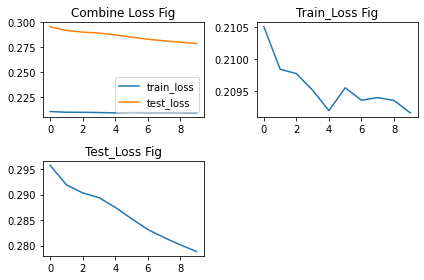


 EPOCH 11/50 	 train loss 0.20896344736587902 	 test loss 0.2775547621680088

 EPOCH 12/50 	 train loss 0.20903732362857536 	 test loss 0.2760291334058418

 EPOCH 13/50 	 train loss 0.20912114056673917 	 test loss 0.2743765565215564

 EPOCH 14/50 	 train loss 0.20897117922128725 	 test loss 0.2709703914454726

 EPOCH 15/50 	 train loss 0.20891660895229372 	 test loss 0.2662025826876281


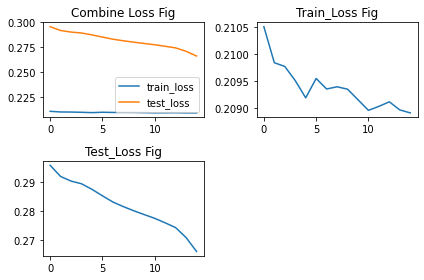


 EPOCH 16/50 	 train loss 0.2088998093092737 	 test loss 0.2617205479105965

 EPOCH 17/50 	 train loss 0.20863346225959212 	 test loss 0.2579409411696137

 EPOCH 18/50 	 train loss 0.20877222975423512 	 test loss 0.25398176224505314

 EPOCH 19/50 	 train loss 0.20866466356703073 	 test loss 0.2496684965540151

 EPOCH 20/50 	 train loss 0.20828099684281784 	 test loss 0.24468134270339717


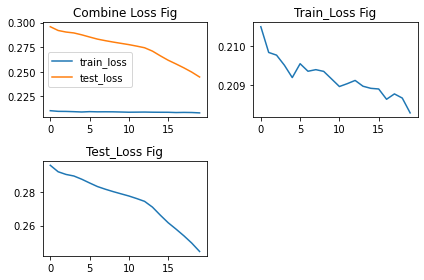


 EPOCH 21/50 	 train loss 0.208642468964758 	 test loss 0.2397809341305592

 EPOCH 22/50 	 train loss 0.20853054819028238 	 test loss 0.23551328846665678

 EPOCH 23/50 	 train loss 0.2084966710776337 	 test loss 0.22991658038780338

 EPOCH 24/50 	 train loss 0.20875134349854524 	 test loss 0.2219716369128618

 EPOCH 25/50 	 train loss 0.2084078118820821 	 test loss 0.21319526922507365


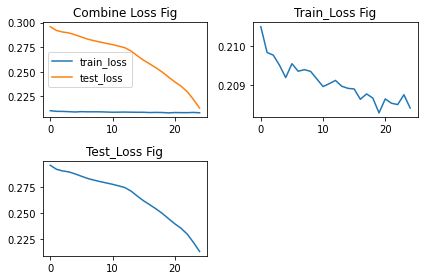


 EPOCH 26/50 	 train loss 0.2087936756039454 	 test loss 0.20682896942388815

 EPOCH 27/50 	 train loss 0.208795352415605 	 test loss 0.20389833606657434

 EPOCH 28/50 	 train loss 0.2086877665243858 	 test loss 0.201312924994797

 EPOCH 29/50 	 train loss 0.20859342764231784 	 test loss 0.19906277734725203

 EPOCH 30/50 	 train loss 0.20868501781432097 	 test loss 0.19699417958494092


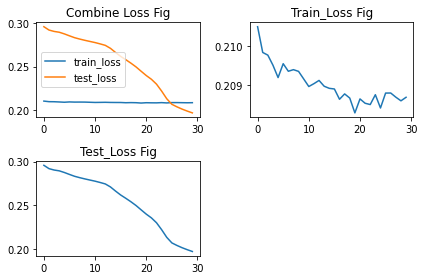


 EPOCH 31/50 	 train loss 0.20817876256201878 	 test loss 0.1954196711055568

 EPOCH 32/50 	 train loss 0.20827998996766145 	 test loss 0.19375750275908923

 EPOCH 33/50 	 train loss 0.20832960073612938 	 test loss 0.19271425340996415

 EPOCH 34/50 	 train loss 0.20834418761828713 	 test loss 0.19210534017594133

 EPOCH 35/50 	 train loss 0.20810858671330223 	 test loss 0.19104433059692383


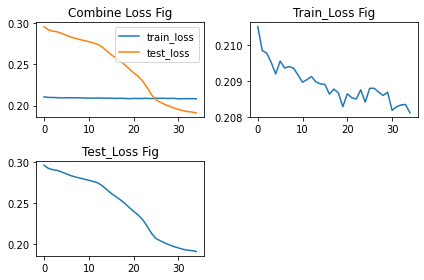


 EPOCH 36/50 	 train loss 0.20849643659985756 	 test loss 0.1918213562887223

 EPOCH 37/50 	 train loss 0.20877679911526767 	 test loss 0.19279411190845927

 EPOCH 38/50 	 train loss 0.20910672707991165 	 test loss 0.1926764582024246

 EPOCH 39/50 	 train loss 0.20927915100223762 	 test loss 0.19201578859423027

 EPOCH 40/50 	 train loss 0.20894497879280532 	 test loss 0.1927867482920162


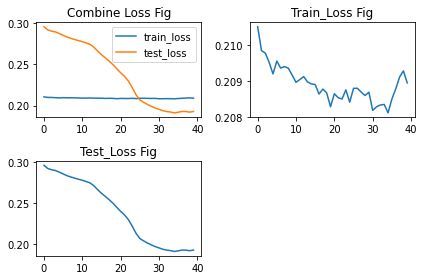


 EPOCH 41/50 	 train loss 0.20913514223965732 	 test loss 0.19286513719402376

 EPOCH 42/50 	 train loss 0.20909368696291586 	 test loss 0.19377823344996717

 EPOCH 43/50 	 train loss 0.2089618217846579 	 test loss 0.19358889783015015

 EPOCH 44/50 	 train loss 0.20916848537350488 	 test loss 0.19312008873361056

 EPOCH 45/50 	 train loss 0.20916686176268523 	 test loss 0.1924611623169946


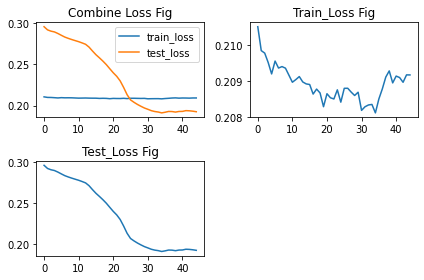


 EPOCH 46/50 	 train loss 0.2091603121481651 	 test loss 0.19253425910824634

 EPOCH 47/50 	 train loss 0.20935265682945567 	 test loss 0.19163673432146916

 EPOCH 48/50 	 train loss 0.2090763040810577 	 test loss 0.19192945761758773

 EPOCH 49/50 	 train loss 0.20866080552093252 	 test loss 0.19190346608396436

 EPOCH 50/50 	 train loss 0.2089455285348183 	 test loss 0.19187528578961482


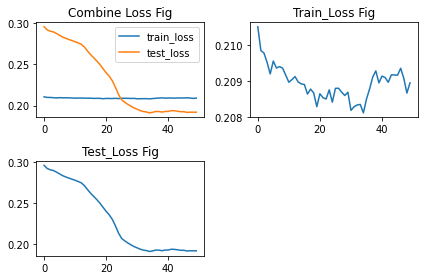

In [92]:
num_epochs = 50
all_loss = {'train_loss':[],'test_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(encoder,decoder, train_loader,optim)
   test_loss = test_epoch(encoder,decoder,test_loader)
   print('\n EPOCH {}/{} \t train loss {} \t test loss {}'.format(epoch + 1, num_epochs,train_loss,test_loss))
   all_loss['train_loss'].append(train_loss)
   all_loss['test_loss'].append(test_loss)
   if epoch and (epoch + 1) % 5 == 0:
      plot_train(all_loss, seperate=True)